In [28]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [29]:
df = pd.read_csv('data/fake_news.csv', parse_dates=['timestamp'])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[['timestamp', 'baseurl', 'content']], df['label'],
    test_size=0.25, random_state=42,
)

(sec:fake_news_modeling)=
# Modeling

Now that we've obtained, cleaned, and explored our data, let's fit models to predict whether articles are real or fake. Since we're classifying articles, we'll use logistic regression. We'll fit three different models that increase in complexity. First, we'll fit a model that just uses a single hand-picked word as a binary feature. Then, we'll fit a model that uses multiple hand-picked words. Finally, we'll fit a model that uses all the words in the training set, vectorized using the tf-idf transform. Let's start with the simple single-word model.

## A Single-Word Model

From our EDA, we know that many articles were published soon after the 2016 US Presidential Election. In that election, the two candidates were named Donald Trump and Hillary Clinton. Readers who followed the election that year may already know that the election was quite divisive, which suggests that the word `trump` could be predictive of whether articles in our dataset are real or fake. To test this, we'll fit a logistic regression classifier using a single binary feature: `1` if the word `trump` appears in the article and `0` if not. Since we'll want to add more word features like this one later in this analysis, we'll write the code so that it can extend to multiple words.

We'll start by defining functions to lowercase the article content and create binary word features.

In [224]:
def lowercase(df):
    return df.assign(content=df['content'].str.lower())

In [225]:
# This function creates one new binary feature for each word in word_features,
# marking the presence of a word in an article.
def make_word_features(df, words=word_features):
    features = { word: df['content'].str.contains(word) for word in words }
    return pd.DataFrame(features)

We can chain these functions into a `scikit-learn` pipeline, which provides a convenient way to transform and fit data all at once.

In [226]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV

In [227]:
# For our first classifier, we'll only use the word `trump`.
word_features = [
    'trump',
]

In [228]:
from sklearn.preprocessing import FunctionTransformer

model1 = make_pipeline(
    FunctionTransformer(lowercase),
    FunctionTransformer(make_word_features, kw_args={'words': word_features}),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=4,
                         max_iter=10000)
)

The pipeline above will lowercase the article content, create word features, and fit a logistic regression on the data. Using `LogisticRegressionCV` will by default use 5-fold cross-validation to select the best regularization parameter for the data.

Now, we can use the pipeline to fit the training data:

In [229]:
%%time

model1.fit(X_train, y_train)
print(f'{model1.score(X_train, y_train):.1%} accuracy on training set.')

68.7% accuracy on training set.
CPU times: user 109 ms, sys: 20.1 ms, total: 129 ms
Wall time: 108 ms


We can plot a confusion matrix of the classifier on the training set to see what kinds of mistakes it made:

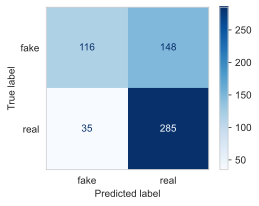

In [231]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model1, X_train, y_train,
                      cmap=plt.cm.Blues)
plt.grid(False);

Overall, the single-word classifier only classifies 68.7% of articles correctly. It often misclassifies `fake` articles as `real`.

Since this model is simple, we can take a look at the parameters to understand
how it behaves completely.

In [233]:
log_reg = model1.named_steps['logisticregressioncv']
coefs = (pd.DataFrame({'word': word_features, 'coef': log_reg.coef_[0]})
         .set_index('word')
         .sort_values('coef')
        )
coefs

,coef
word,
trump,-0.97


In [234]:
intercept = log_reg.intercept_[0]
print(f'Intercept: {intercept:.2f}')

Intercept: 0.45


Since the model has an intercept of 0.45 and the model weight for the `trump` feature is `-0.97`, the model will always predict that articles that contain the word `trump` are `fake` and articles that don't contain `trump` are `real`. We encourage readers to verify this for themselves using the definition of the logistic regression model.

Let's make our model a bit more sophisticated by introducing additional word features.

## Multiple Word Model

We can reuse much of the same code to create a model that uses multiple binary word features. To create our features, we'll use some domain knowledge about controversial topics during the 2016-2018 period:

In [237]:
word_features = [
    # names of presidential candidates
    'trump', 'donald', 'hillary', 'clinton',
    
    # other possibly useful words
    'military', 'state', 'vote', 'congress', 'fbi', 'shutdown',
    'investig', 'antifa', 'joke', 'princ', 'homeless', 'cnn',
]

There are 16 features in this model. Let's fit a model using these features.

In [238]:
from sklearn.preprocessing import FunctionTransformer

model2 = make_pipeline(
    FunctionTransformer(lowercase),
    FunctionTransformer(make_word_features, kw_args={'words': word_features}),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=4,
                         max_iter=10000)
)

In [239]:
%%time

model2.fit(X_train, y_train)
print(f'{model2.score(X_train, y_train):.1%} accuracy on training set.')

74.0% accuracy on training set.
CPU times: user 1.76 s, sys: 18.1 ms, total: 1.78 s
Wall time: 769 ms


This model performed significantly better than the one-word model on the training set. Let's plot a confusion matrix again:

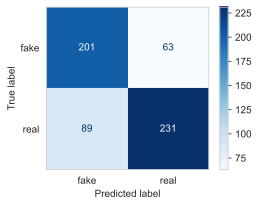

In [240]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model2, X_train, y_train,
                      cmap=plt.cm.Blues)
plt.grid(False);

We can see that this classifier does a better job classifying `fake` articles accurately. However, it makes more mistakes than the simple one-word model when classifying `real` articles -- 89 of `real` articles were classified as `fake.

Let's take a look at the model's coefficients:

In [241]:
log_reg = model2.named_steps['logisticregressioncv']
coefs = (pd.DataFrame({'word': word_features, 'coef': log_reg.coef_[0]})
         .set_index('word')
         .sort_values('coef')
        )
dfs_side_by_side(coefs.iloc[:8], coefs.iloc[8:])

,coef
word,
trump,-0.96
donald,-0.39
investig,-0.25
fbi,-0.13
joke,-0.13
cnn,-0.07
antifa,-0.04
homeless,0.06
,coef


We can interpret the weights by looking at their signs. For example, the negative weights on `trump` and `donald` indicate that the model predicts that new articles that have these words have a lower probability of being real. The reverse is true for words like `congress` and `vote`, which have positive weights.

Although this model performs better than the simple one-word model, we still had to hand-pick the word features using our knowledge of the news. What if we forgot to include words that are highly predictive? To address this, we can incorporate all the words in the articles using the tf-idf transform.

## Predicting with the tf-idf Transform

Let's use the tf-idf transform from {numref}`Section %s <sec:text_sotu>` to vectorize the entire text of all articles in the training set. This means that our classifier will be able to use all the words in the training set's news articles for prediction. As we've done when we introduced tf-idf, we'll first remove stopwords, tokenize the words, then use the `TfidfVectorizer` from `scikit-learn`.

In [247]:
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = set(nltk.corpus.stopwords.words('english'))
porter_stemmer = PorterStemmer()

def stemming_tokenizer(document):
    return [porter_stemmer.stem(word)
            for word in nltk.word_tokenize(document)
            if word not in stop_words]
    return words

In [248]:
tfidf = TfidfVectorizer(tokenizer=stemming_tokenizer)

In [249]:
from sklearn.compose import make_column_transformer

model3 = make_pipeline(
    FunctionTransformer(lowercase),
    make_column_transformer((tfidf, 'content')),
    LogisticRegressionCV(Cs=10,
                         solver='saga',
                         n_jobs=8,
                         max_iter=1000),
    verbose=True,
)

In [250]:
%%time

model3.fit(X_train, y_train)
print(f'{model3.score(X_train, y_train):.1%} accuracy on training set.')

[Pipeline]  (step 1 of 3) Processing functiontransformer, total=   0.0s
[Pipeline] . (step 2 of 3) Processing columntransformer, total=  14.0s
[Pipeline]  (step 3 of 3) Processing logisticregressioncv, total=   5.7s
100.0% accuracy on training set.
CPU times: user 49.9 s, sys: 263 ms, total: 50.1 s
Wall time: 34.1 s


We find that this model achieves 100% accuracy on the training set. We can take a look at the tf-idf transformer to better understand the model. Let's start by finding out how many unique tokens the classifier uses:

In [251]:
tfidf = model3.named_steps.columntransformer.named_transformers_.tfidfvectorizer
n_unique_tokens = len(tfidf.vocabulary_.keys())
print(f'{n_unique_tokens} tokens appeared across {len(X_train)} examples.')

23804 tokens appeared across 584 examples.


This means that our classifier has 23,804 features, a large increase from our previous model which only had 16. Since we can't display that many model weights, we'll display the ten most negative and ten most positive weights below:

In [253]:
log_reg = model3.named_steps.logisticregressioncv
coefs = (pd.DataFrame(tfidf.vocabulary_.keys(),
                      columns=['word'],
                      index=tfidf.vocabulary_.values())
         .sort_index()
         .assign(coef=log_reg.coef_[0])
         .sort_values('coef')
        )
dfs_side_by_side(coefs.iloc[:10], coefs.iloc[-10:])

,word,coef
21441,trump,-10.90
23776,”,-10.76
23775,“,-9.71
0,!,-9.10
23773,‘,-8.92
22092,vaccin,-8.36
7370,comment,-8.26
21361,trendolizer™,-8.24
12531,investig,-7.94
13601,like,-7.82


Displaying these features shows a few quirks about this model. For example, we see that several influential features correspond to punctuation in the original text. It's unclear whether we should clean out the punctuation in the model. On one hand, punctuation doesn't seem to convey as much information as words do. On the other, it seems plausible that lots of explanation points in an article could help a model decide whether the article is real or fake. In this case, we've decided to keep punctuation, but curious readers can repeat this analysis after stripping the punctuation out to see how the resulting model is affected.

Let's conclude by displaying the test set error for all three models:

In [257]:
pd.DataFrame({
    'test set error': [model1.score(X_test, y_test),
                       model2.score(X_test, y_test),
                       model3.score(X_test, y_test)]
}, index=['model1', 'model2', 'model3'])

,test set error
model1,0.64
model2,0.69
model3,0.88


As we might expect, the models became more accurate as we introduced more features. The final model that used tf-idf performed significantly better than the models with binary hand-picked word features. This illustrates a common tradeoff in modeling: given enough data, more complex models can often outperform simpler ones, especially in situations like our case study where simpler models have too much model bias to perform well. However, complex models can be more difficult to interpret. For example, our tf-idf model had over 23,804 features which makes it harder to concisely explain to another person how our model makes its decisions.

In addition, we need to be careful about what our models are useful for. In this case, our models use the content of the news articles for prediction, making them highly dependent on the words that appear in the training set. However, our models will likely not perform as well on future news articles that use words that didn't appear in the training set. For example, our models use the US election candidates' names in 2016 for prediction, but won't know to incorporate the names of the candidates in 2020 or 2024. To use our models in the longer term, we would need to address this issue of *drift*. 

That said, it's surprising that a logistic regression model can perform well with a relatively small amount of feature engineering (tf-idf). We've addressed our original research question: our tf-idf model appears effective for detecting fake news in our dataset, and could plausibly generalize to other news published in the same time period covered in the training data.